# 💧 10-Year and 100-Year Floods in Your Favorite Rivers

**Hands-on Hydrology Lab — Undergraduate Course**  
Instructor: *[Your Name]*  
Environment: Jupyter Notebook (Binder-ready)

In this lab, you'll explore real river data from the USGS to estimate 10-year and 100-year flood magnitudes using **Extreme Value Analysis**.

By the end of this exercise, you'll be able to:
- Understand return periods and exceedance probabilities.
- Retrieve USGS annual peak discharge data using Python.
- Fit a **Gumbel distribution** to estimate flood magnitudes.
- Visualize flood frequency curves.
- Compare 10-year and 100-year floods across rivers.

In [1]:
# 🧩 Setup
# Import required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gumbel_r
import dataretrieval.nwis as nwis

plt.style.use('seaborn-v0_8')
pd.options.display.float_format = '{:,.2f}'.format

print('Environment ready!')

Environment ready!


## 🌊 What is a Return Period?

The **return period** (or recurrence interval) represents the *average* interval of time between events of a certain magnitude or greater.

- A **10-year flood** has a 10% chance of being exceeded in any given year.
- A **100-year flood** has a 1% chance of being exceeded in any given year.

These are **probabilities**, not predictions — two 100-year floods can happen in consecutive years!

In [2]:
# 🏞️ Choose a USGS Site
# Examples:
# - 06752000: Cache la Poudre River near Fort Collins, CO
# - 07010000: Mississippi River at St. Louis, MO
# - 01463500: Delaware River at Trenton, NJ
# - 01646500: Potomac River at Point of Rocks, MD
# - 09380000: San Juan River near Bluff, UT

site = "09380000"  # <-- You can change this!
print(f"Selected USGS site: {site}")

Selected USGS site: 09380000


In [3]:
# 📥 Retrieve Annual Peak Flow Data from USGS NWIS

peaks = nwis.get_record(sites=site, service='peaks')
print(f"Retrieved {len(peaks)} records from USGS site {site}.")
peaks

Retrieved 103 records from USGS site 09380000.


/global/homes/l/lizh142/.conda/envs/atsww/lib/python3.10/site-packages/dataretrieval/nwis.py:109: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datetime'] = pd.to_datetime(df.pop('peak_dt'), errors='coerce')


,agency_cd,site_no,peak_tm,peak_va,peak_cd,gage_ht,gage_ht_cd,year_last_pk,ag_dt,ag_tm,ag_gage_ht,ag_gage_ht_cd
datetime,,,,,,,,,,,,
1921-06-18 00:00:00+00:00,USGS,09380000,NaN,170000,"2,R",26.50,3,NaN,NaN,NaN,NaN,NaN
1922-05-31 00:00:00+00:00,USGS,09380000,NaN,116000,NaN,19.80,3,NaN,NaN,NaN,NaN,NaN
1923-05-31 00:00:00+00:00,USGS,09380000,NaN,98300,NaN,17.50,6,NaN,NaN,NaN,NaN,NaN
1924-06-17 00:00:00+00:00,USGS,09380000,NaN,76200,NaN,15.20,NaN,NaN,NaN,NaN,NaN,NaN
1925-06-03 00:00:00+00:00,USGS,09380000,NaN,54900,NaN,13.60,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-11-06 00:00:00+00:00,USGS,09380000,15:15,39700,6,13.32,NaN,NaN,NaN,NaN,NaN,NaN
2020-08-17 00:00:00+00:00,USGS,09380000,22:30,21300,6,10.80,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-23 00:00:00+00:00,USGS,09380000,07:15,20200,6,10.77,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# 📥 Retrieve and Clean Annual Peak Flow Data from USGS NWIS (final robust version)

print(f"Attempting to retrieve annual peak data for site {site}...")

# Try to get 'peaks' data first
peaks = nwis.get_record(sites=site, service='peaks')

if peaks.empty:
    print("⚠️ No annual peak data found. Falling back to daily streamflow (dv) records.")
    
    # Retrieve daily mean streamflow data for long period (adjust as needed)
    daily = nwis.get_record(sites=site, service='dv', start='1950-01-01')
    
    # Identify the discharge column (usually contains '00060_Mean')
    flow_col = None
    for c in daily.columns:
        if '00060' in c or 'discharge' in c.lower():
            flow_col = c
            break
    if flow_col is None:
        raise ValueError("Could not find discharge column in daily data.")
    
    # Compute annual maximum flows
    daily = daily[[flow_col]].dropna()
    daily.index = pd.to_datetime(daily.index)
    data = (
        daily.resample('Y').max()
        .rename(columns={flow_col: 'peak_flow_cfs'})
        .reset_index()
    )
    data['year'] = data['datetime'].dt.year
else:
    print(f"✅ Retrieved {len(peaks)} annual peak records.")
    
    # Handle the case where date is the index
    if isinstance(peaks.index, pd.DatetimeIndex):
        peaks = peaks.reset_index().rename(columns={'index': 'peak_dt'})
    
    # Find the date column (index or explicit)
    date_col = None
    for c in peaks.columns:
        if 'peak_dt' in c or 'peak_date' in c or 'datetime' in c:
            date_col = c
            break
    if date_col is None and isinstance(peaks.index, pd.DatetimeIndex):
        date_col = peaks.index.name
    
    # Find the discharge column
    flow_col = None
    for c in peaks.columns:
        if 'peak_va' in c or 'discharge' in c.lower() or 'flow' in c.lower():
            flow_col = c
            break

    if flow_col is None:
        raise ValueError("Could not find discharge column in NWIS data.")
    
    # Prepare the data
    data = peaks[[date_col, flow_col]].dropna().copy()
    data['year'] = pd.to_datetime(data[date_col]).dt.year
    data = data.rename(columns={flow_col: 'peak_flow_cfs'})
    data = data.groupby('year', as_index=False)['peak_flow_cfs'].max()

print(f"Data covers {data['year'].min()}–{data['year'].max()} ({len(data)} years)")
data

Attempting to retrieve annual peak data for site 09380000...
✅ Retrieved 103 annual peak records.
Data covers 1921–2023 (96 years)


/global/homes/l/lizh142/.conda/envs/atsww/lib/python3.10/site-packages/dataretrieval/nwis.py:109: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['datetime'] = pd.to_datetime(df.pop('peak_dt'), errors='coerce')


,year,peak_flow_cfs
0,1921,170000
1,1922,116000
2,1923,98300
3,1924,76200
4,1925,54900
...,...,...
91,2018,39700
92,2020,21300
93,2021,20200
94,2022,16200


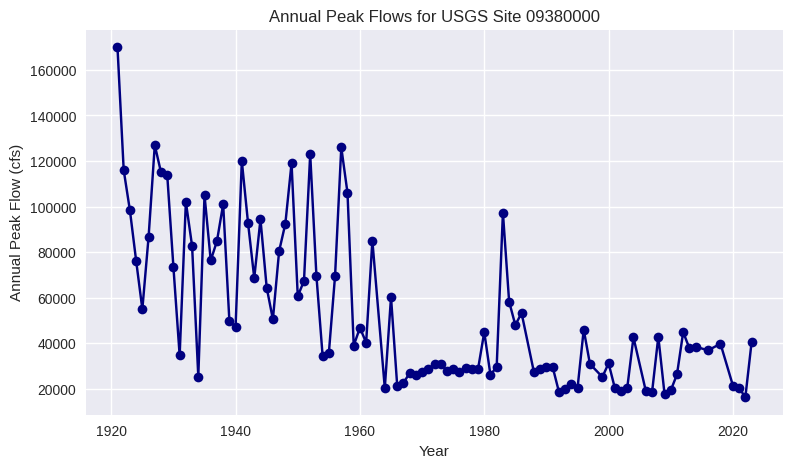

In [5]:
# 📊 Visualize Annual Peak Flows

plt.figure(figsize=(9,5))
plt.plot(data['year'], data['peak_flow_cfs'], color='navy', marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Annual Peak Flow (cfs)')
plt.title(f'Annual Peak Flows for USGS Site {site}')
plt.grid(True)
plt.show()

In [6]:
# 📈 Fit Gumbel Distribution to Annual Peak Flows

x = data['peak_flow_cfs'].values
loc, scale = gumbel_r.fit(x)
print(f"Fitted Gumbel parameters: loc = {loc:.2f}, scale = {scale:.2f}")

# Define return periods (years)
T = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 50, 100, 200])
prob_exceed = 1 / T

# Quantiles from the fitted distribution
Q = gumbel_r.ppf(1 - prob_exceed, loc=loc, scale=scale)

results = pd.DataFrame({
    'Return Period (yrs)': T,
    'Exceedance Probability': prob_exceed,
    'Estimated Flood (cfs)': Q
})
results

Fitted Gumbel parameters: loc = 38181.94, scale = 23435.07


,Return Period (yrs),Exceedance Probability,Estimated Flood (cfs)
0,2,0.50,"46,771.20"
1,3,0.33,"59,337.26"
2,4,0.25,"67,379.68"
3,5,0.20,"73,333.14"
4,6,0.17,"78,068.04"
5,7,0.14,"82,001.41"
6,8,0.12,"85,366.55"
7,9,0.11,"88,307.47"
8,10,0.10,"90,919.45"
9,15,0.07,"100,841.50"


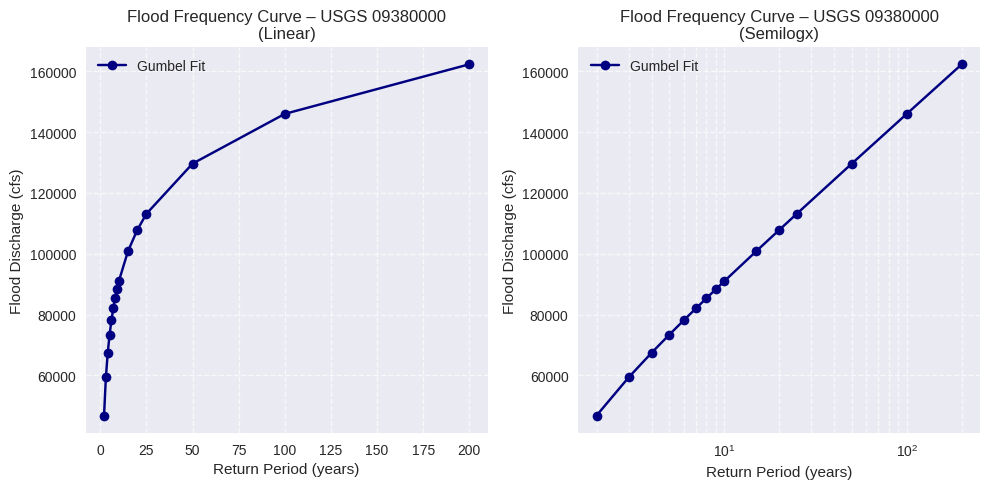

In [7]:
# 📉 Plot Flood Frequency Curve

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(T, Q, color='navy', marker='o', linestyle='-', label='Gumbel Fit')
ax1.set_xlabel('Return Period (years)')
ax1.set_ylabel('Flood Discharge (cfs)')
ax1.set_title(f'Flood Frequency Curve – USGS {site}\n(Linear)')
ax1.grid(True, which='both', linestyle='--', alpha=0.7)
ax1.legend()
ax2.semilogx(T, Q, color='navy', marker='o', linestyle='-', label='Gumbel Fit')
ax2.set_xlabel('Return Period (years)')
ax2.set_ylabel('Flood Discharge (cfs)')
ax2.set_title(f'Flood Frequency Curve – USGS {site}\n(Semilogx)')
ax2.grid(True, which='both', linestyle='--', alpha=0.7)
ax2.legend()
plt.tight_layout()
plt.show()

In [8]:
# 🔍 Extract Key Flood Estimates

Q10 = results.loc[results['Return Period (yrs)'] == 10, 'Estimated Flood (cfs)'].values[0]
Q100 = results.loc[results['Return Period (yrs)'] == 100, 'Estimated Flood (cfs)'].values[0]

print(f"Estimated 10-year flood:  {Q10:,.0f} cfs")
print(f"Estimated 100-year flood: {Q100:,.0f} cfs")

Estimated 10-year flood:  90,919 cfs
Estimated 100-year flood: 145,987 cfs


## 🚀 Try It Yourself

1. Change the **`site`** variable above to another river (see suggestions below).
2. Rerun all cells to see how the results differ.
3. Discuss: Why do flood magnitudes differ between rivers?

**Suggested Sites:**
- 01646500 — Potomac River at Point of Rocks, MD  
- 05555500 — Illinois River at Peoria, IL  
- 09380000 — San Juan River near Bluff, UT  
- 01463500 — Delaware River at Trenton, NJ  

Find more site numbers here: [https://nwis.waterdata.usgs.gov/usa/nwis/peak](https://nwis.waterdata.usgs.gov/usa/nwis/peak)

## 🧠 Discussion Questions

1. What does a *100-year flood* really mean?
2. What assumptions does the Gumbel model make?
3. How might climate change affect flood frequency analyses?
4. How could you improve this analysis using longer datasets or different distributions?